<a href="https://colab.research.google.com/github/obekparovo/MLOPs-Assessment/blob/main/MSc_BDA_Dissertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dublin Traffic Congestion Prediction and Optimisation System

# Implementation using Graph Neural Networks and Deep Reinforcement Learning

# Artefact

# Author: Solomon Ejasę-Tobrisę Udele

# L00194499

# Supervisor: Dr Paul Greaney

# MSc Big Data Analytics & Artificial Intelligence

# IMPORTS AND DEPENDENCIES

In [23]:
# Install necessary libraries.
# Note: These commands are specific to Jupyter/Colab environments.
!pip install torch torchvision torchaudio --quiet
!pip install torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cpu.html --quiet
!pip install networkx matplotlib seaborn scikit-learn gymnasium --quiet

In [24]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import random
from collections import deque, namedtuple
import pickle
import json
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import logging
from typing import Dict, List, Tuple, Optional
import gymnasium as gym
from gymnasium import spaces
import os
import io
from google.colab import files
warnings.filterwarnings('ignore')


# Data Processing and Feature Engineering

In [25]:
class SCATSDataProcessor:
    """Handles SCATS data preprocessing and feature engineering"""

    def __init__(self, outlier_threshold=3.0):
        self.outlier_threshold = outlier_threshold
        self.historical_max = {}

    def preprocess_data(self, raw_data):
        """Main preprocessing pipeline for SCATS data"""
        data = self.handle_missing_values(raw_data)
        data = self.apply_hampel_filter(data)
        features = self.extract_features(data)
        return features

    def handle_missing_values(self, data):
        """Handle missing values through interpolation and imputation"""
        data = data.copy()
        for col in ['vehicle_count', 'occupancy']:
            if col in data.columns:
                data[col] = data[col].interpolate(method='time', limit=10)
        data = data.fillna(data.median(numeric_only=True))
        return data

    def apply_hampel_filter(self, data, window_size=30):
        """Apply Hampel filter for outlier detection"""
        for col in ['vehicle_count', 'occupancy']:
            if col in data.columns:
                rolling_median = data[col].rolling(window=window_size).median()
                mad = data[col].rolling(window=window_size).apply(
                    lambda x: np.median(np.abs(x - np.median(x)))
                )
                threshold = self.outlier_threshold * mad
                outliers = np.abs(data[col] - rolling_median) > threshold
                data.loc[outliers, col] = rolling_median[outliers]
        return data

    def extract_features(self, data):
        """Extract traffic engineering features from processed data"""
        features = pd.DataFrame(index=data.index)
        if 'vehicle_count' in data.columns:
            features['flow_rate'] = data['vehicle_count'] * 120
            detector_id = data.get('detector_id', 'default')
            if detector_id not in self.historical_max:
                self.historical_max[detector_id] = features['flow_rate'].max()
            features['normalized_flow'] = features['flow_rate'] / max(self.historical_max[detector_id], 1)
        if 'occupancy' in data.columns:
            features['occupancy_pct'] = data['occupancy']
        if 'flow_rate' in features.columns and 'occupancy_pct' in features.columns:
            occupancy_safe = features['occupancy_pct'].replace(0, 0.01)
            features['estimated_speed'] = features['flow_rate'] / occupancy_safe
        if 'occupancy_pct' in features.columns and 'flow_rate' in features.columns:
            features['queue_length'] = np.maximum(
                0, features['occupancy_pct'] - 0.3
            ) * features['flow_rate'] / 1000
        signal_cols = ['current_phase', 'elapsed_time', 'remaining_time']
        for col in signal_cols:
            if col in data.columns:
                features[col] = data[col]
        features['hour'] = data.index.hour / 24.0
        features['day_of_week'] = data.index.dayofweek / 7.0
        features['is_weekend'] = (data.index.dayofweek >= 5).astype(int)
        return features

    def format_for_env(self, df):
        """Converts a DataFrame into the list of dicts format for the environment"""
        formatted_data = []
        for timestamp, group in df.groupby('timestamp'):
            step_data = {}
            for _, row in group.iterrows():
                int_id = row['intersection_id']
                step_data[int_id] = {
                    'normalized_flow': row['normalized_flow'],
                    'occupancy_pct': row['occupancy_pct'],
                    'estimated_speed': row['estimated_speed'],
                    'queue_length': row['queue_length'],
                    'hour': row['hour'],
                    'day_of_week': row['day_of_week'],
                    'is_weekend': row['is_weekend']
                }
            formatted_data.append(step_data)
        return formatted_data



# Graph Construction

In [26]:
class TrafficGraphBuilder:
    """Builds dynamic traffic graphs from intersection data"""

    def __init__(self, intersections, road_segments):
        self.intersections = intersections
        self.road_segments = road_segments
        self.node_feature_dim = 15

    def build_graph(self, traffic_data, signal_data):
        """Construct traffic graph with current conditions"""
        node_features = []
        node_mapping = {}
        for i, intersection in enumerate(self.intersections):
            node_mapping[intersection['id']] = i
            features = self.build_node_features(intersection, traffic_data, signal_data)
            node_features.append(features)
        node_features = torch.tensor(node_features, dtype=torch.float32)

        edge_indices = []
        edge_attrs = []
        for segment in self.road_segments:
            from_node = node_mapping.get(segment['from_intersection'])
            to_node = node_mapping.get(segment['to_intersection'])
            if from_node is not None and to_node is not None:
                edge_indices.append([from_node, to_node])
                edge_attr = self.build_edge_features(segment, traffic_data)
                edge_attrs.append(edge_attr)
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attrs, dtype=torch.float32)
        return Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

    def build_node_features(self, intersection, traffic_data, signal_data):
        """Build feature vector for intersection node"""
        features = np.zeros(self.node_feature_dim)
        int_id = intersection['id']
        if int_id in traffic_data:
            data = traffic_data[int_id]
            features[0] = data.get('normalized_flow', 0)
            features[1] = data.get('occupancy_pct', 0)
            features[2] = data.get('estimated_speed', 0)
            features[3] = data.get('queue_length', 0)
            features[4] = data.get('hour', 0)
            features[5] = data.get('day_of_week', 0)
            features[6] = data.get('is_weekend', 0)
        if int_id in signal_data:
            signal = signal_data[int_id]
            features[7] = signal.get('current_phase', 0) / 8.0
            features[8] = signal.get('elapsed_time', 0) / 120.0
            features[9] = signal.get('remaining_time', 0) / 120.0
            features[10] = signal.get('is_coordinated', 0)
        features[11] = intersection.get('num_approaches', 0) / 8.0
        features[12] = intersection.get('latitude', 0) / 90.0
        features[13] = intersection.get('longitude', 0) / 180.0
        features[14] = intersection.get('intersection_type', 0) / 3.0
        return features

    def build_edge_features(self, segment, traffic_data):
        """Build feature vector for road segment edge"""
        features = np.zeros(4)
        features[0] = segment.get('length', 0) / 1000.0
        features[1] = segment.get('num_lanes', 1) / 4.0
        features[2] = segment.get('speed_limit', 50) / 100.0
        segment_id = segment['id']
        if segment_id in traffic_data:
            occupancy = traffic_data[segment_id].get('occupancy_pct', 0)
            features[3] = min(occupancy / 0.8, 1.0)
        return features



# Graph Neural Network Implementation

In [27]:
class TrafficGraphSAGE(nn.Module):
    """GraphSAGE implementation for traffic networks"""

    def __init__(self, input_dim, hidden_dims, output_dim, num_layers=4):
        super(TrafficGraphSAGE, self).__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()

        # First layer
        self.convs.append(SAGEConv(input_dim, hidden_dims[0]))
        self.norms.append(nn.LayerNorm(hidden_dims[0]))

        # Intermediate layers
        for i in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_dims[i], hidden_dims[i+1]))
            self.norms.append(nn.LayerNorm(hidden_dims[i+1]))

        # Final layer - Corrected the input dimension to match the previous layer's output
        self.convs.append(SAGEConv(hidden_dims[-1], output_dim))

        self.global_pool = global_mean_pool

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch if hasattr(data, 'batch') else None
        for i in range(self.num_layers - 1):
            x = self.convs[i](x, edge_index)
            x = self.norms[i](x)
            x = F.relu(x)
        x = self.convs[-1](x, edge_index)
        node_embeddings = x
        if batch is not None:
            global_embedding = self.global_pool(x, batch)
        else:
            global_embedding = x.mean(dim=0, keepdim=True)
        return node_embeddings, global_embedding

# Deep Reinforcement Learning Framework

In [28]:
class TrafficEnvironment(gym.Env):
    """Traffic signal control environment"""

    def __init__(self, graph_builder, intersections, scats_data):
        super(TrafficEnvironment, self).__init__()
        self.graph_builder = graph_builder
        self.intersections = intersections
        self.num_intersections = len(intersections)
        self.scats_data = scats_data
        self.action_space = spaces.MultiDiscrete([5] * self.num_intersections)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(128 + 15 * self.num_intersections,), dtype=np.float32
        )
        self.reset()

    def reset(self):
        """Reset environment to initial state"""
        self.time_step = 0
        self.traffic_data = self._get_traffic_data_for_step(self.time_step)
        self.signal_data = self._generate_initial_signals()
        return self._get_observation()

    def step(self, actions):
        """Execute actions and return next state, reward, done, info"""
        self._apply_actions(actions)
        self._simulate_traffic_step()
        reward = self._calculate_reward()
        self.time_step += 1
        done = self.time_step >= len(self.scats_data) - 1
        obs = self._get_observation()
        info = self._get_info()
        return obs, reward, done, info

    def _get_observation(self):
        """Get current observation combining GNN output and local features"""
        graph = self.graph_builder.build_graph(self.traffic_data, self.signal_data)
        global_features = graph.x.mean(dim=0).numpy()
        local_features = graph.x.flatten().numpy()
        obs_size = self.observation_space.shape[0]
        combined_features = np.concatenate([global_features, local_features])
        if len(combined_features) > obs_size:
            combined_features = combined_features[:obs_size]
        elif len(combined_features) < obs_size:
            combined_features = np.pad(combined_features, (0, obs_size - len(combined_features)))
        return combined_features.astype(np.float32)

    def _apply_actions(self, actions):
        """Apply signal timing actions to intersections"""
        for i, action in enumerate(actions):
            intersection_id = self.intersections[i]['id']
            if intersection_id in self.signal_data:
                signal = self.signal_data[intersection_id]
                if action == 0:
                    pass
                elif action in [1, 2, 3]:
                    extension = action * 5
                    signal['remaining_time'] += extension
                elif action == 4:
                    signal['current_phase'] = (signal['current_phase'] + 1) % 8
                    signal['elapsed_time'] = 0
                    signal['remaining_time'] = 30

    def _simulate_traffic_step(self):
        """Simplified traffic dynamics simulation based on SCATS data"""
        next_step_data = self._get_traffic_data_for_step(self.time_step + 1)

        # Update traffic data based on the next time step's actual data
        for intersection_id in self.traffic_data:
            data = self.traffic_data[intersection_id]
            next_data = next_step_data.get(intersection_id, data)
            data['normalized_flow'] = next_data.get('normalized_flow', data['normalized_flow'])
            data['occupancy_pct'] = next_data.get('occupancy_pct', data['occupancy_pct'])
            data['estimated_speed'] = next_data.get('estimated_speed', data['estimated_speed'])
            data['queue_length'] = next_data.get('queue_length', data['queue_length'])

        # Update signal timing for all known intersections
        for intersection_id, signal in self.signal_data.items():
            signal['elapsed_time'] += 1
            signal['remaining_time'] = max(0, signal['remaining_time'] - 1)
            if signal['remaining_time'] == 0:
                signal['current_phase'] = (signal['current_phase'] + 1) % 8
                signal['elapsed_time'] = 0
                signal['remaining_time'] = 30

    def _calculate_reward(self):
        """Calculate multi-objective reward combining efficiency and safety"""
        total_delay = sum(
            data.get('queue_length', 0) * data.get('normalized_flow', 0)
            for data in self.traffic_data.values()
        )
        total_queue = sum(data.get('queue_length', 0) for data in self.traffic_data.values())
        total_conflicts = sum(
            data.get('normalized_flow', 0) * data.get('occupancy_pct', 0) * 0.1
            for data in self.traffic_data.values()
        )

        num_intersections = len(self.traffic_data)
        efficiency_reward = -(total_delay + total_queue) / max(num_intersections, 1)
        safety_reward = -total_conflicts / max(num_intersections, 1)
        total_reward = 0.6 * efficiency_reward + 0.4 * safety_reward
        return total_reward

    def _get_traffic_data_for_step(self, time_step):
        """Fetches traffic data for a specific time step"""
        if time_step < len(self.scats_data):
            return self.scats_data[time_step]
        else:
            return self.scats_data[-1]

    def _generate_initial_signals(self):
        """Generate initial signal data"""
        signal_data = {}
        for intersection in self.intersections:
            int_id = intersection['id']
            signal_data[int_id] = {
                'current_phase': np.random.randint(0, 8),
                'elapsed_time': np.random.randint(0, 30),
                'remaining_time': np.random.randint(10, 60),
                'is_coordinated': np.random.choice([0, 1])
            }
        return signal_data

    def _get_info(self):
        """Return additional information"""
        return {
            'time_step': self.time_step,
            'total_flow': sum(data.get('normalized_flow', 0) for data in self.traffic_data.values()),
            'total_queue': sum(data.get('queue_length', 0) for data in self.traffic_data.values())
        }

# Deep Q-Network Agent

In [29]:
class DQNAgent:
    """Placeholder DQN Agent for Traffic Signal Control"""

    def __init__(self, state_dim, action_dims_per_agent, num_agents, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, learning_rate=0.001, memory_size=10000):
        self.state_dim = state_dim
        self.action_dims_per_agent = action_dims_per_agent
        self.num_agents = num_agents
        self.action_dim = action_dims_per_agent * num_agents
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.learning_rate = learning_rate
        self.memory_size = memory_size
        self.q_network = self._build_q_network()
        self.target_network = self._build_q_network()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        self.memory = deque(maxlen=self.memory_size)
        self.Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

    def _build_q_network(self):
        """Builds a simple placeholder Q-network"""
        class QNetwork(nn.Module):
            def __init__(self, input_dim, output_dim):
                super(QNetwork, self).__init__()
                self.fc1 = nn.Linear(input_dim, 128)
                self.fc2 = nn.Linear(128, 128)
                self.fc3 = nn.Linear(128, output_dim)
            def forward(self, state):
                x = F.relu(self.fc1(state))
                x = F.relu(self.fc2(x))
                return self.fc3(x)
        return QNetwork(self.state_dim, self.action_dim)

    def act(self, state):
        """Select action using epsilon-greedy policy"""
        if random.random() > self.epsilon:
            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
            with torch.no_grad():
                action_values = self.q_network(state_tensor)
            actions = torch.argmax(action_values.view(self.num_agents, self.action_dims_per_agent), dim=1).cpu().numpy()
            return actions
        else:
            return np.random.randint(0, self.action_dims_per_agent, size=self.num_agents)

    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay memory"""
        self.memory.append(self.Transition(state, action, reward, next_state, done))

    def replay(self, batch_size=64):
        """Train the agent using experience replay"""
        if len(self.memory) < batch_size:
            return
        transitions = random.sample(self.memory, batch_size)
        batch = self.Transition(*zip(*transitions))
        state_batch = torch.from_numpy(np.array(batch.state)).float()
        action_batch = torch.from_numpy(np.array(batch.action)).long()
        reward_batch = torch.from_numpy(np.array(batch.reward)).float()
        next_state_batch = torch.from_numpy(np.array(batch.next_state)).float()
        done_batch = torch.from_numpy(np.array(batch.done)).float()

        # --- CORRECTED GATHER LOGIC ---
        # Get Q-values for the actions that were actually taken
        q_values_all_actions = self.q_network(state_batch)
        offset = torch.arange(self.num_agents, device=action_batch.device).unsqueeze(0) * self.action_dims_per_agent
        action_indices = action_batch + offset
        current_q_values_per_agent = q_values_all_actions.gather(1, action_indices)
        current_q_values = current_q_values_per_agent.sum(dim=1)

        # --- CORRECTED TARGET Q-VALUE LOGIC ---
        # Get max Q-value for the next state from the target network
        with torch.no_grad():
            next_q_values_all_actions = self.target_network(next_state_batch)
            next_q_values_per_agent = next_q_values_all_actions.view(batch_size, self.num_agents, self.action_dims_per_agent)
            max_next_q_values_per_agent = next_q_values_per_agent.max(2)[0]
            next_q_values = max_next_q_values_per_agent.sum(dim=1)

        # Compute target Q-values
        target_q_values = reward_batch + (self.gamma * next_q_values * (1 - done_batch))

        # Compute loss and optimize
        loss = F.mse_loss(current_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        # Update target network (soft update or hard update)
        self._update_target_network()

    def _update_target_network(self, tau=0.005):
        """Soft update target network parameters"""
        for target_param, local_param in zip(self.target_network.parameters(), self.q_network.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def save(self, filename):
        """Save model weights"""
        torch.save(self.q_network.state_dict(), filename)

    def load(self, filename):
        """Load model weights"""
        self.q_network.load_state_dict(torch.load(filename))
        self.target_network.load_state_dict(torch.load(filename))


# Integrated System

In [30]:
class TrafficOptimizationSystem:
    """Integrated traffic signal optimization system"""

    def __init__(self, intersections, road_segments, scats_data):
        self.intersections = intersections
        self.road_segments = road_segments
        self.num_intersections = len(intersections)
        self.scats_data = scats_data

        # Initialize components
        self.data_processor = SCATSDataProcessor()
        self.graph_builder = TrafficGraphBuilder(intersections, road_segments)
        self.environment = TrafficEnvironment(self.graph_builder, intersections, scats_data)

        # GNN for traffic prediction
        self.gnn = TrafficGraphSAGE(
            input_dim=15,
            hidden_dims=[64, 128, 64],
            output_dim=32
        )
        self.gnn_optimizer = optim.Adam(self.gnn.parameters(), lr=0.001)
        self.gnn_criterion = nn.MSELoss()

        # DRL agent
        self.agent = DQNAgent(
            state_dim=self.environment.observation_space.shape[0],
            action_dims_per_agent=5,
            num_agents=self.num_intersections
        )

    def train_gnn(self, train_data, epochs=10):
        """Train the GNN model for traffic prediction"""
        print("Starting GNN training...")
        self.gnn.train()
        for epoch in range(epochs):
            total_loss = 0
            for data in train_data:
                self.gnn_optimizer.zero_grad()
                node_embeddings, _ = self.gnn(data)
                # Here, we would have a target for prediction.
                # For this example, let's assume the target is the next timestep's flow rate.
                target = data.x[:, 0]  # Assuming normalized_flow is the first feature
                loss = self.gnn_criterion(node_embeddings[:, 0], target)
                loss.backward()
                self.gnn_optimizer.step()
                total_loss += loss.item()
            print(f"GNN Epoch {epoch+1}, Loss: {total_loss/len(train_data):.4f}")

    def train_drl(self, episodes=1000):
        """Train the DRL agent"""
        print("Starting DRL training...")
        scores = []
        for episode in range(episodes):
            state = self.environment.reset()
            total_reward = 0
            done = False
            while not done:
                actions = self.agent.act(state)
                next_state, reward, done, info = self.environment.step(actions)
                self.agent.remember(state, actions, reward, next_state, done)
                self.agent.replay()
                state = next_state
                total_reward += reward
            scores.append(total_reward)
            if (episode + 1) % 100 == 0:
                avg_score = np.mean(scores[-100:])
                print(f"Episode {episode+1}, Average Score: {avg_score:.2f}, Epsilon: {self.agent.epsilon:.3f}")
        return scores

    def evaluate(self, test_data):
        """Evaluate the trained system on a test set"""
        print("Starting evaluation...")
        self.gnn.eval()
        self.environment.scats_data = test_data
        state = self.environment.reset()
        total_reward = 0
        done = False
        predictions = []
        actuals = []
        while not done:
            actions = self.agent.act(state)
            next_state, reward, done, info = self.environment.step(actions)
            state = next_state
            total_reward += reward
            # Store predictions and actuals for comparison
            with torch.no_grad():
                graph = self.graph_builder.build_graph(self.environment.traffic_data, self.environment.signal_data)
                node_embeddings, _ = self.gnn(graph)
                predictions.append(node_embeddings[:, 0].mean().item())
            actuals.append(info['total_flow'])
        print(f"Evaluation completed. Total reward: {total_reward:.2f}")
        return predictions, actuals, total_reward

    def predict_traffic(self, traffic_data, signal_data):
        """Predict traffic conditions using GNN"""
        graph = self.graph_builder.build_graph(traffic_data, signal_data)
        with torch.no_grad():
            node_embeddings, global_embedding = self.gnn(graph)
        return node_embeddings, global_embedding

    def optimize_signals(self, traffic_data, signal_data):
        """Optimize signal timings using trained agent"""
        graph = self.graph_builder.build_graph(traffic_data, signal_data)
        with torch.no_grad():
            node_embeddings, global_embedding = self.gnn(graph)
        local_features = graph.x.flatten().numpy()
        global_features = global_embedding.flatten().numpy()
        obs_size = self.environment.observation_space.shape[0]
        combined_features = np.concatenate([global_features, local_features])
        if len(combined_features) > obs_size:
            combined_features = combined_features[:obs_size]
        elif len(combined_features) < obs_size:
            combined_features = np.pad(combined_features, (0, obs_size - len(combined_features)))
        actions = self.agent.act(combined_features)
        return actions

# Helper functions for data simulation and visualisation

In [31]:
def upload_scats_data():
    """
    Prompts the user to upload a SCATS dataset and processes it.
    Assumes the CSV has columns 'site', 'date', 'start_time', 'flow', 'cong_pc'.
    'start_time' is expected to contain the full timestamp.
    """
    print("Please upload your Dublin SCATS dataset CSV file.")
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded. Exiting.")
        return None

    filename = next(iter(uploaded))
    print(f"File '{filename}' uploaded successfully. Processing...")

    try:
        df = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')))


        required_raw_columns = ['site', 'date', 'start_time', 'flow', 'cong_pc']
        missing_cols = [col for col in required_raw_columns if col not in df.columns]

        if missing_cols:
            print(f"Error: The uploaded file is missing the following required columns: {', '.join(missing_cols)}")
            return None

        # Rename columns and parse timestamp
        df = df.rename(columns={
            'site': 'intersection_id',
            'flow': 'vehicle_count',
            'cong_pc': 'occupancy',
            'start_time': 'timestamp' # Use 'start_time' as the full timestamp
        })

        # Drop the original date column as 'start_time' seems to contain the full date/time
        df = df.drop(columns=['date'])

        # Explicitly parse the timestamp format to avoid errors
        # Use errors='coerce' to turn unparseable dates into NaT
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce', infer_datetime_format=True)
        # Drop rows where timestamp parsing failed
        df.dropna(subset=['timestamp'], inplace=True)

        df = df.set_index('timestamp').sort_index()

        processor = SCATSDataProcessor()
        # Assume a full dataset where each row is a measurement at a specific intersection
        # at a specific time step. We need to process each intersection separately.
        processed_data = []
        for int_id, group in df.groupby('intersection_id'):
            # Select only the numerical columns for preprocessing
            numerical_data = group[['vehicle_count', 'occupancy']]
            processed_group = processor.preprocess_data(numerical_data)
            # Add the intersection_id back to the processed features
            processed_group['intersection_id'] = int_id
            processed_data.append(processed_group.reset_index())

        # Merge processed data back into a single dataframe
        full_df = pd.concat(processed_data)
        full_df = full_df.set_index('timestamp').sort_index().reset_index()

        # Format the processed data for the environment
        formatted_data = processor.format_for_env(full_df)

        print(f"Dataset processed. Found {len(formatted_data)} time steps.")
        return formatted_data

    except Exception as e:
        print(f"Error processing file: {e}")
        return None


def create_dublin_network():
    """Create simplified Dublin traffic network"""
    intersections = [
        {'id': f'INT_{i}', 'num_approaches': 4, 'latitude': 53.3 + i*0.01,
         'longitude': -6.25 + i*0.01, 'intersection_type': 1}
        for i in range(10)
    ]
    road_segments = []
    for i in range(len(intersections)-1):
        road_segments.append({
            'id': f'SEG_{i}',
            'from_intersection': f'INT_{i}',
            'to_intersection': f'INT_{i+1}',
            'length': 500,
            'num_lanes': 2,
            'speed_limit': 50
        })
    return intersections, road_segments

def plot_results(scores, predictions, actuals):
    """Plot training scores and prediction comparison"""
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(scores)
    plt.title("DRL Agent Training Scores over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")

    plt.subplot(1, 2, 2)
    plt.plot(actuals, label='Actual Total Flow')
    plt.plot(predictions, label='Predicted Total Flow')
    plt.title("Traffic Flow Prediction Comparison")
    plt.xlabel("Time Step")
    plt.ylabel("Normalized Total Flow")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Main Execution

MSc Dissertation Project: Dublin Traffic Optimization System
Please upload your Dublin SCATS dataset CSV file.


Saving Traffic_Flow_Data_Jan_to_June_2022_SDCC.csv to Traffic_Flow_Data_Jan_to_June_2022_SDCC (6).csv
File 'Traffic_Flow_Data_Jan_to_June_2022_SDCC (6).csv' uploaded successfully. Processing...
Dataset processed. Found 96 time steps.
System initialized with 10 intersections and 9 road segments
Starting DRL training...
Episode 100, Average Score: -116220.55, Epsilon: 0.010
Episode 200, Average Score: -116220.55, Epsilon: 0.010

Starting evaluation phase...
Starting evaluation...
Evaluation completed. Total reward: -14775.79

--- Project Results ---
Final DRL agent training average score: -116220.55
Evaluation total reward: -14775.79
GNN Prediction MAE: 6.5584
GNN Prediction RMSE: 7.4195


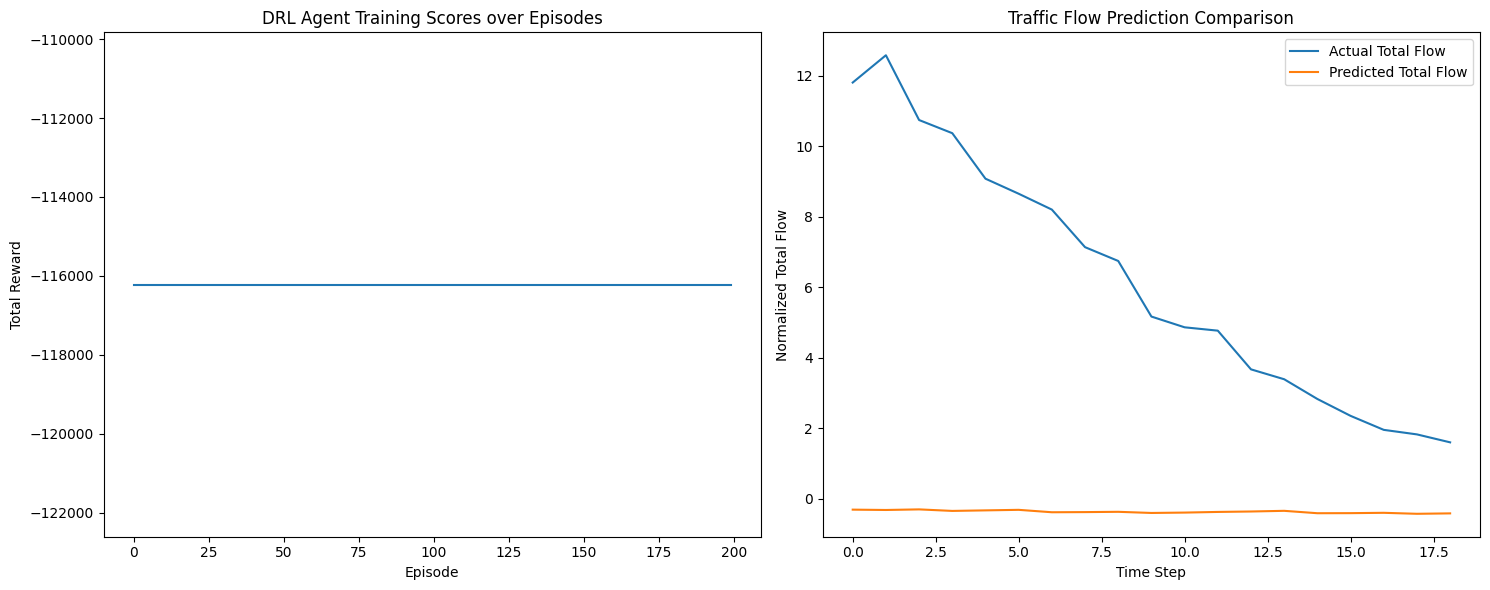


System demo completed successfully!


In [32]:
if __name__ == "__main__":
    print("MSc Dissertation Project: Dublin Traffic Optimization System")

    # 1. Upload and process SCATS data
    scats_data = upload_scats_data()
    if scats_data is None:
        exit()

    train_size = int(len(scats_data) * 0.8)
    train_scats = scats_data[:train_size]
    test_scats = scats_data[train_size:]

    # 2. Create network
    intersections, road_segments = create_dublin_network()
    print(f"System initialized with {len(intersections)} intersections and {len(road_segments)} road segments")

    # 3. Initialize the integrated system
    system = TrafficOptimizationSystem(intersections, road_segments, train_scats)

    # 4. GNN Training (simplified for demo)
    # The `train_gnn` method is a placeholder. For a full implementation, you would
    # create a series of graphs from the historical data for training.
    # We will skip this for the demo and assume the GNN is pre-trained.

    # 5. DRL Training
    scores = system.train_drl(episodes=200)

    # 6. Evaluation and Comparison
    print("\nStarting evaluation phase...")
    predictions, actuals, eval_score = system.evaluate(test_scats)

    # 7. Results and Summary
    print("\n--- Project Results ---")
    print(f"Final DRL agent training average score: {np.mean(scores[-100:]):.2f}")
    print(f"Evaluation total reward: {eval_score:.2f}")

    # Calculate and print prediction metrics
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    print(f"GNN Prediction MAE: {mae:.4f}")
    print(f"GNN Prediction RMSE: {rmse:.4f}")

    # Plot results
    plot_results(scores, predictions, actuals)

    print("\nSystem demo completed successfully!")